In [ ]:
%load_ext autoreload
%autoreload 2

import collections
import copy
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import tensor
import tqdm
from typing import Any

import block_formats.experiments as E

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

In [2]:
# This takes a long time (multiple minutes) to run
runs = E.runs("20250425-grid-compressed", progress=True)
display(dict(collections.Counter(run.config.model for run in runs)))
display(dict(collections.Counter(run.meta.status for run in runs)))

query: 56431it [04:06, 229.06it/s]


{'meta-llama/Llama-3.2-1B': 17767,
 'google/gemma-3-1b-pt': 3089,
 'Qwen/Qwen2.5-1.5B': 17767,
 'meta-llama/Llama-3.2-3B': 17767,
 'google/gemma-3-4b-pt': 41}

{'finished': 53734, 'failed': 2686, 'running': 11}

## (Minor) Size optimisation

The majority of the space is taken storing `summary.params`. We could save some space by deleting `nelement` and `rms`, as these are easily retrieved from the `weight-stats` sweep. Beyond this, we could store aggregates rather than per-parameter values, which we're unlikely to need.

In [3]:
key_to_size = collections.defaultdict(float)
summary_key_to_size = collections.defaultdict(float)
for run in runs[:10000]:
    for k in run:
        key_to_size[k] += len(json.dumps(run[k]))
    if "summary" in run:
        for k in run.summary:
            summary_key_to_size[k] += len(json.dumps(run.summary[k]))

print("Run:")
display({k: f"{key_to_size[k] / 2**20:.0f} MiB" for k in sorted(key_to_size, key=key_to_size.__getitem__, reverse=True)})
print("Summary:")
display({k: f"{summary_key_to_size[k] / 2**20:.0f} MiB" for k in sorted(summary_key_to_size, key=summary_key_to_size.__getitem__, reverse=True)})
print("Summary.params example:")
display([(k, v) for k, v in runs[0].summary.params.items() if "rmse" in v][0])

Run:


{'summary': '172 MiB',
 'config': '7 MiB',
 'meta': '2 MiB',
 'error': '1 MiB',
 'id': '0 MiB',
 'experiment': '0 MiB',
 'run_id': '0 MiB'}

Summary:


{'params': '157 MiB',
 'kl_div': '7 MiB',
 'cross_entropy': '7 MiB',
 'bits_per_param': '0 MiB'}

Summary.params example:


('model.layers.7.mlp.gate_proj.weight',
 {'bits': 50331664.0,
  'rmse': 0.0055958997,
  'rms': 0.021040821,
  'nelement': 16777216.0})

In [ ]:
def compress_runs():
    """Remove some redundant information from the logs, to download them faster."""
    runs_old = E.runs("20250425-grid", progress=True)
    for run in tqdm.tqdm(runs_old):
        run = copy.deepcopy(run)
        run["experiment"] = "20250425-grid-compressed"
        if "summary" in run and "params" in run["summary"]:
            params = run["summary"]["params"]
            for key in list(params):
                value = params[key]
                if "rmse" not in value:
                    del params[key]
                else:
                    del value["rms"]
                    del value["nelement"]
        E.core.update_run(run)
# compress_runs()

## Failures

Most of the failures are configuration errors - runs with weighting + compression. Note that there are also non-error duplicate runs with weighting + absmax (except Lloyd-Max).

- Remove runs for weighting+compression, weighting+absmax(except-lloyd-max)
- What to do with large blocks - pad? skip?
- Investigate Lloyd-Max:E7M0:absmax errors


In [3]:
def sorted_counts(d: list[Any]) -> None:
    counts = dict(collections.Counter(d))
    return {k: counts[k] for k in sorted(counts, key=lambda k: (counts[k], k), reverse=True)}

failed = [r for r in runs if r.meta.status == "failed"]

print("# Top-level errors:")
display(sorted_counts([f.error.message for f in failed]))

print("# Causes:")
display(sorted_counts([f.error.cause.message or f.error.cause.trace[-1] for f in failed if "cause" in f.error]))

print("# NaNs")
display(sorted_counts([f.config.test.fmt_str for f in failed if f.error.message.endswith("=nan")]))

print("# Asserts")
display(sorted_counts([f.config.test.fmt_str for f in failed if "cause" in f.error and f.error.cause.type == "AssertionError"]))

# Top-level errors:


{"Failed to quantise 'model.embed_tokens.weight'": 2295,
 "Failed to quantise 'model.layers.14.self_attn.o_proj.weight'": 72,
 'Bad value summary.params.model.embed_tokens.weight.rmse=nan': 52,
 "Failed to quantise 'model.layers.24.self_attn.o_proj.weight'": 36,
 "Failed to quantise 'model.layers.11.self_attn.o_proj.weight'": 36,
 "Failed to quantise 'model.layers.9.self_attn.o_proj.weight'": 18,
 "Failed to quantise 'model.layers.25.self_attn.o_proj.weight'": 18,
 "Failed to quantise 'model.layers.2.self_attn.o_proj.weight'": 18,
 "Failed to quantise 'model.layers.2.mlp.up_proj.weight'": 18,
 "Failed to quantise 'model.layers.19.self_attn.o_proj.weight'": 18,
 "Failed to quantise 'model.layers.12.self_attn.o_proj.weight'": 18,
 'Bad value summary.params.model.layers.0.mlp.gate_proj.weight.rmse=nan': 12,
 'Bad value summary.params.model.layers.1.mlp.gate_proj.weight.rmse=nan': 11,
 'Bad value summary.params.model.layers.0.mlp.up_proj.weight.rmse=nan': 9,
 'Bad value summary.params.mode

# Causes:


{"fit.Scaled with compression doesn't support error weighting": 1890,
 "shape '[262144, 1, 4, 256]' is invalid for input of size 301989888": 405,
 '  File "/home/ubuntu/nethome-us-east-1/douglaso/SquashedLlama/20250127-FormatsCascade/block_formats/quantisation.py", line 623, in lut_lloyd_max\n    assert (midpoints[:-1] <= midpoints[1:]).all().item()\n': 252}

# NaNs


{'5b-lloyd_max{1,*:E7M0:absmax}+S[0.8%:BFLOAT16]': 9,
 '5b-lloyd_max{*,*:E7M0:absmax}': 9,
 '4b-lloyd_max{1,*:E7M0:absmax}+S[0.8%:BFLOAT16]': 9,
 '4b-lloyd_max{*,*:E7M0:absmax}': 9,
 '3b-lloyd_max{*,*:E7M0:absmax}': 9,
 '5b-lloyd_max{1,*:E7M0:absmax}+S[1e-03:BFLOAT16]': 8,
 '4b-lloyd_max{1,*:E7M0:absmax}+S[1e-03:BFLOAT16]': 8,
 '4b-lloyd_max{1,256:E7M0:absmax}+S[0.8%:BFLOAT16]': 7,
 '3b-lloyd_max{1,*:E7M0:absmax}+S[0.8%:BFLOAT16]': 7,
 '5b-lloyd_max{1,256:E7M0:absmax}+S[1e-03:BFLOAT16]': 6,
 '5b-lloyd_max{1,256:E7M0:absmax}+S[0.8%:BFLOAT16]': 6,
 '3b-lloyd_max{1,256:E7M0:absmax}+S[0.8%:BFLOAT16]': 6,
 '5b-lloyd_max{1,128:E7M0:absmax}+S[0.8%:BFLOAT16]': 5,
 '5b-lloyd_max{1,*:E7M0:absmax}': 5,
 '4b-lloyd_max{1,*:E7M0:absmax}': 5,
 '3b-lloyd_max{1,*:E7M0:absmax}+S[1e-03:BFLOAT16]': 5,
 '4b-lloyd_max{1,256:E7M0:absmax}+S[1e-03:BFLOAT16]': 3,
 '4b-lloyd_max{1,128:E7M0:absmax}+S[0.8%:BFLOAT16]': 3,
 '3b-lloyd_max{1,256:E7M0:absmax}+S[1e-03:BFLOAT16]': 3,
 '3b-lloyd_max{1,*:E7M0:absmax}': 3,


# Asserts


{'5b-lloyd_max{1,32:E7M0:absmax}+S[1e-03:BFLOAT16]': 18,
 '5b-lloyd_max{1,32:E7M0:absmax}+S[0.8%:BFLOAT16]': 18,
 '5b-lloyd_max{1,16:E7M0:absmax}+S[1e-03:BFLOAT16]': 18,
 '5b-lloyd_max{1,16:E7M0:absmax}+S[0.8%:BFLOAT16]': 18,
 '4b-lloyd_max{1,32:E7M0:absmax}+S[1e-03:BFLOAT16]': 18,
 '4b-lloyd_max{1,32:E7M0:absmax}+S[0.8%:BFLOAT16]': 18,
 '4b-lloyd_max{1,16:E7M0:absmax}+S[1e-03:BFLOAT16]': 18,
 '4b-lloyd_max{1,16:E7M0:absmax}+S[0.8%:BFLOAT16]': 18,
 '3b-lloyd_max{1,32:E7M0:absmax}+S[1e-03:BFLOAT16]': 18,
 '3b-lloyd_max{1,32:E7M0:absmax}+S[0.8%:BFLOAT16]': 18,
 '3b-lloyd_max{1,16:E7M0:absmax}+S[1e-03:BFLOAT16]': 18,
 '3b-lloyd_max{1,16:E7M0:absmax}+S[0.8%:BFLOAT16]': 18,
 '5b-lloyd_max{1,64:E7M0:absmax}+S[1e-03:BFLOAT16]': 6,
 '5b-lloyd_max{1,64:E7M0:absmax}+S[0.8%:BFLOAT16]': 6,
 '4b-lloyd_max{1,64:E7M0:absmax}+S[1e-03:BFLOAT16]': 6,
 '4b-lloyd_max{1,64:E7M0:absmax}+S[0.8%:BFLOAT16]': 6,
 '3b-lloyd_max{1,64:E7M0:absmax}+S[1e-03:BFLOAT16]': 6,
 '3b-lloyd_max{1,64:E7M0:absmax}+S[0.8%:BFLO

## Runs and duration

In [5]:
sorted_counts([run.config.model for run in runs if run.error is None])

{'Qwen/Qwen2.5-1.5B': 17093,
 'meta-llama/Llama-3.2-3B': 17074,
 'meta-llama/Llama-3.2-1B': 17046,
 'google/gemma-3-1b-pt': 2493,
 'google/gemma-3-4b-pt': 39}

In [6]:
durations = collections.defaultdict(list)
for run in runs:
    if run.error is None and "duration" in run.meta:
        durations[run.config.model].append(run.meta.duration)
display({k: sum(v) / len(v) for k, v in sorted(durations.items())})

{'Qwen/Qwen2.5-1.5B': 11.86906306234131,
 'google/gemma-3-1b-pt': 194.73834653236833,
 'google/gemma-3-4b-pt': 229.82279529411767,
 'meta-llama/Llama-3.2-1B': 8.621094025249324,
 'meta-llama/Llama-3.2-3B': 19.70793517400726}

## Analysis

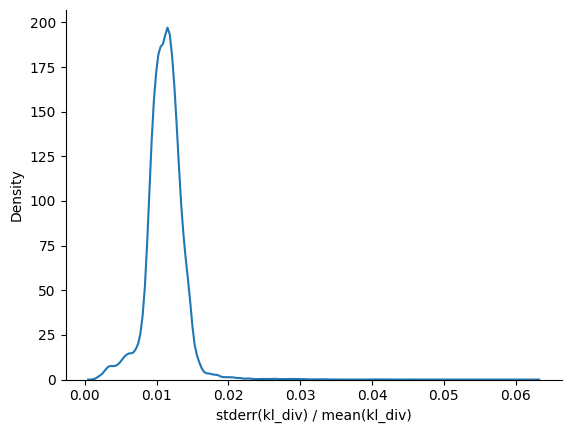

In [7]:
kl_div_stderr_ratio = [
    torch.tensor(run.summary.kl_div).std(unbiased=False).div(len(run.summary.kl_div) ** 0.5).div(torch.tensor(run.summary.kl_div).mean()).item()
    for run in runs
    if "kl_div" in run.summary
]
ax = sns.kdeplot(tensor(kl_div_stderr_ratio))
ax.set_xlabel("stderr(kl_div) / mean(kl_div)");

In [3]:
def pareto_optimal(df: pd.DataFrame) -> pd.Series:
    kl_div = np.array(df.kl_div)
    bits_per_param = np.array(df.bits_per_param)
    optimal = (
        ~((kl_div[None, :] < kl_div[:, None]) & (bits_per_param[None, :] <= bits_per_param[:, None])).any(1)
        & ~((kl_div[None, :] <= kl_div[:, None]) & (bits_per_param[None, :] < bits_per_param[:, None])).any(1)
    )
    return pd.Series(optimal, index=df.index)

def get_element_format_name(fmt: E.AttrDict) -> str:
    name = fmt.element_family
    if name == "fp" and "exponent_bits" in fmt.args:
        name = f"{name}-E{fmt.args.exponent_bits:.0f}"
    if name == "t" and "df" in fmt.args:
        name = f"{name}[{fmt.args.df:.0f}]"
    if fmt.compressor is not None:
        name = f"{name}+Z{fmt.compressor}"
    return name

weight_stats = {run.config.model: run.summary.weight_stats for run in E.runs("20250423-weight-stats")}
fisher_sum = {run.config.model: run.summary.fisher for run in E.runs("20250423-fisher")}

def to_row(run: dict[str, Any]) -> dict[str, Any]:
    test = run.config.test
    if test.type != "baseline" and run.meta.status == "finished":
        fmt = test.fmt
        wstats = weight_stats[run.config.model]
        fisher = fisher_sum[run.config.model]
        sse, fisher_sse = 0, 0
        for k, q in run.summary.params.items():
            sse += (q["rmse"] ** 2) * math.prod(wstats[k].shape)
            fisher_sse += (q["rmse"] ** 2) * fisher[k]
        return dict(
            model=run.config.model.split("/")[1],
            element_bits=fmt.element_bits,
            element_family=fmt.element_family,
            element_name=get_element_format_name(fmt),
            element_mode=fmt.args.get("mode", None),
            scaling=fmt.scaling,
            scale_format="bfloat16" if fmt.scale_format.get("dtype") == "bfloat16" else "E7M0-RI",
            block={(None, None): "tensor", (1, None): "channel"}.get(tuple(fmt.block_shape), fmt.block_shape[1]),
            sparse_ratio=fmt.sparse_ratio,
            compression=fmt.compressor == "optimal",
            error_weight=test.error_weight or "none",
            bit_allocation=test.type.replace("quantise_", ""),
            kl_div=tensor(run.summary.kl_div).mean().item(),
            bits_per_param=run.summary["bits_per_param"],
            sse=sse,
            fisher_sse=fisher_sse,
        )

df = pd.DataFrame.from_records(list(filter(None, map(to_row, tqdm.tqdm(runs)))))
# We accidentally ran some duplicates - setting error_weight when there was nothing to weight!
df = df.pipe(lambda d: d[(d.error_weight == "none") | (d.scaling == "rms") | d.element_family.isin(["lloyd_max", "fp", "t"])])
# The Gemma models were partially sweept, so exclude them
df = df.pipe(lambda d: d[~d.model.isin(["gemma-3-1b-pt", "gemma-3-4b-pt"])])
# Sparse outliers with compression under-report bits_per_param, so we must filter them out
df = df.pipe(lambda d: d[~(d.compression & (d.sparse_ratio != 0))])
df.head()

100%|██████████| 56431/56431 [00:06<00:00, 9346.84it/s] 


,model,element_bits,element_family,element_name,element_mode,scaling,scale_format,block,sparse_ratio,compression,error_weight,bit_allocation,kl_div,bits_per_param,sse,fisher_sse
0,Llama-3.2-1B,3.0,int,int,None,rms,bfloat16,tensor,0.000000,False,none,fixed,7.793500,3.000712,27477.628172,1.645059
1,Llama-3.2-1B,3.0,int,int,None,rms,bfloat16,tensor,0.007812,False,none,fixed,1.025159,3.375692,18158.973940,1.134821
2,Llama-3.2-1B,3.0,int,int,None,rms,bfloat16,tensor,0.000000,False,none,variable,7.080340,3.033803,32498.430904,1.007006
3,Llama-3.2-1B,3.0,int,int,None,rms,bfloat16,tensor,0.000000,False,fisher,heuristic,2.540191,5.047694,16585.464488,0.656766
4,Llama-3.2-1B,3.0,int,int,None,rms,bfloat16,tensor,0.000000,False,fisher,fixed,7.551734,3.000712,33211.891469,13.528092


In [9]:
axes = ["model", "element_bits",
        "element_name", "element_mode", "scaling", "scale_format", "block", "sparse_ratio",
        "error_weight", "bit_allocation"]
assert df.groupby(axes).apply(len, include_groups=False).max() == 1

In [10]:
def filter_df(df: pd.DataFrame, select: dict[str, Any]) -> pd.DataFrame:
    d = df
    for c, value in select.items():
        d = d[d[c] == value].drop(columns=c)
    return d

def show_pareto(select: dict[str, Any], hue: str, hue_norm: matplotlib.colors.Normalize | None = None, col: str = "model") -> None:
    d = (filter_df(df, select).groupby(["model", hue])
        .apply(lambda d: d[pareto_optimal(d)].sort_values("bits_per_param"), include_groups=False)
        .reset_index())

    cols = sorted(df[col].unique())
    fig, axs = plt.subplots(ncols=len(cols), figsize=(3*len(cols), 3), sharey=True)
    for col_value, ax in zip(cols, axs):
        ax = sns.lineplot(data=d[d[col] == col_value], y="kl_div", x="bits_per_param",
                          hue=hue, hue_norm=hue_norm, palette="flare" if d[hue].dtype.kind == "f" else None,
                          marker="o", mew=0, lw=1, ax=ax)
        ax.set_yscale("log")
        ax.set_ylim((3e-3, 1))
        ax.set_xlim((3, 6.2))
        ax.set_title(col_value, fontsize=10)
        ax.legend_.remove()
    fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5), title=hue)
    fig.suptitle(f"Filter: {str(select)}", y=0.95)
    fig.tight_layout()

### Compression is good

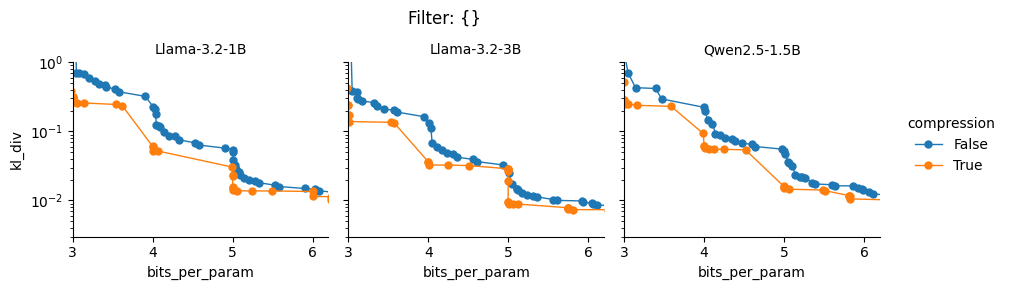

In [11]:
show_pareto(dict(), hue="compression")

### Variable (Fisher) allocation of bit-width per tensor is good

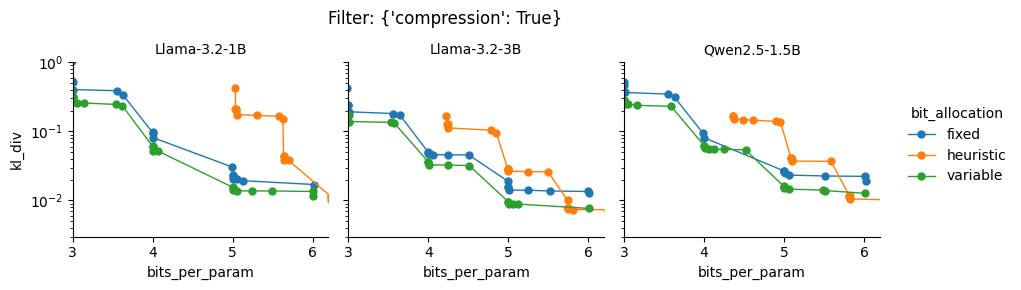

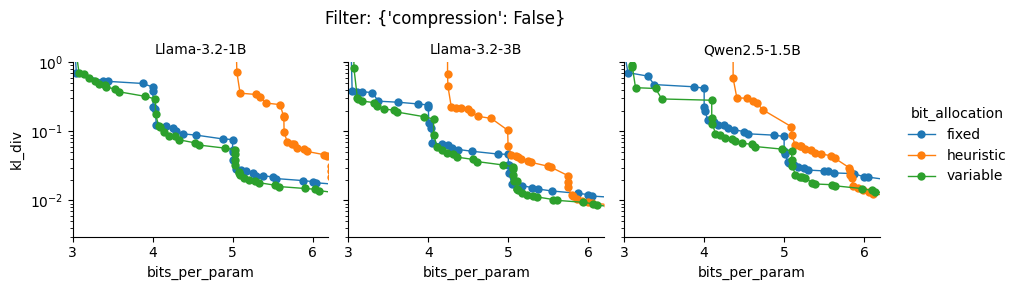

In [12]:
show_pareto(dict(compression=True), hue="bit_allocation")
show_pareto(dict(compression=False), hue="bit_allocation")

### RMS scaling benefits from outlier removal

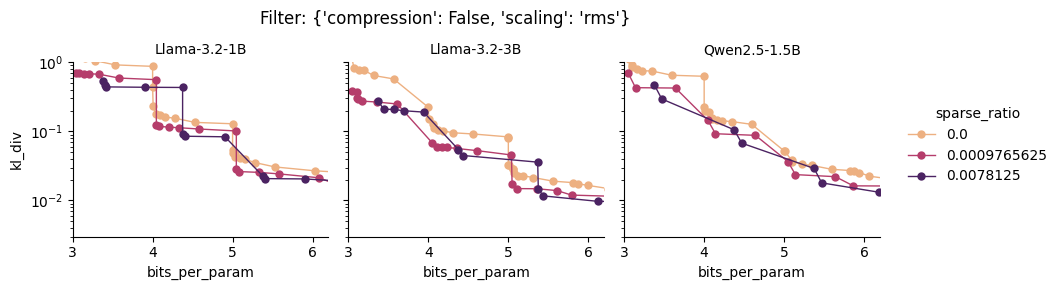

In [13]:
show_pareto(dict(compression=False, scaling="rms"), hue="sparse_ratio", hue_norm=matplotlib.colors.SymLogNorm(2**-10))

### RMS scaling (with outlier removal) doesn't benefit from block scaling

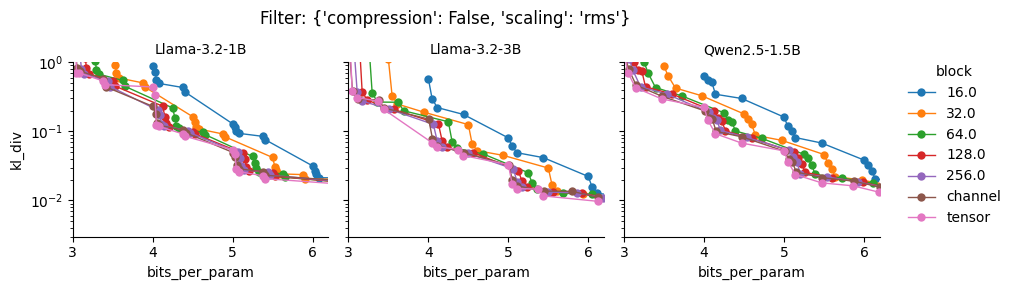

In [14]:
show_pareto(dict(compression=False, scaling="rms"), hue="block")

### Absmax scaling doesn't benefit from outlier removal

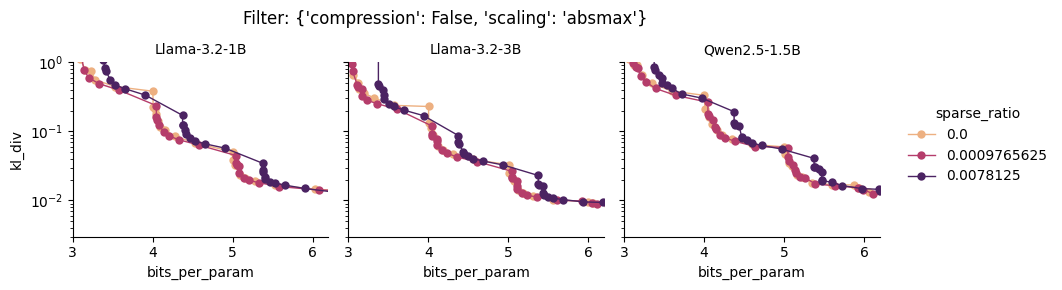

In [15]:
show_pareto(dict(compression=False, scaling="absmax"), hue="sparse_ratio", hue_norm=matplotlib.colors.SymLogNorm(2**-10))

### Absmax scaling (without outlier removal) benefits from block scaling

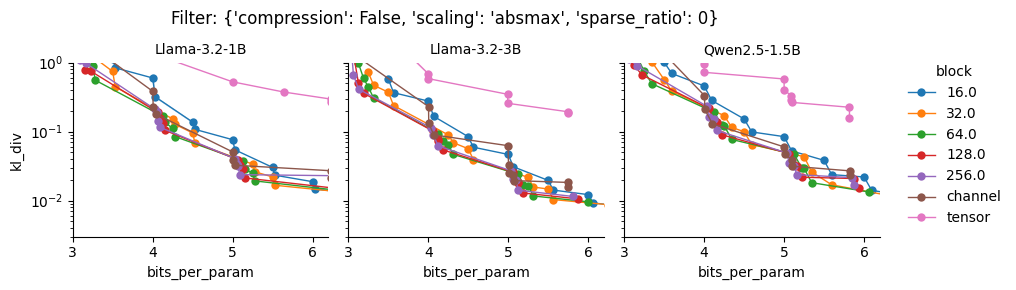

In [16]:
show_pareto(dict(compression=False, scaling="absmax", sparse_ratio=0), hue="block")

### Integer elements benefit from signmax scaling

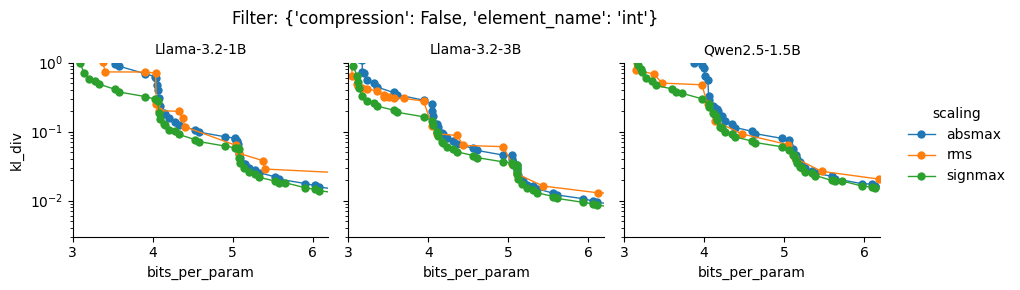

In [17]:
show_pareto(dict(compression=False, element_name="int"), hue="scaling")

### Family differences are minor, but Student-t and Normal are generally good

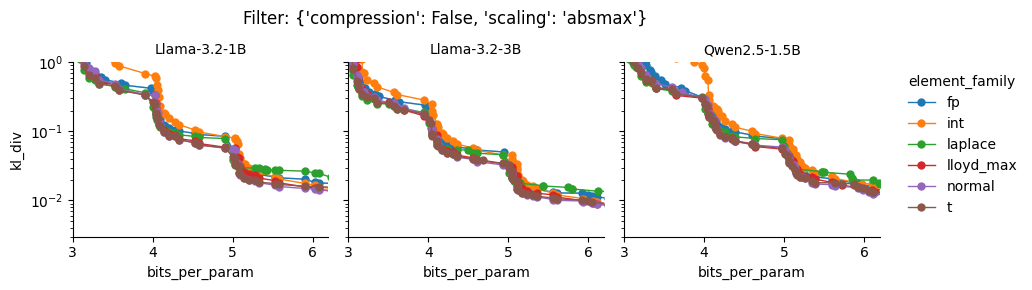

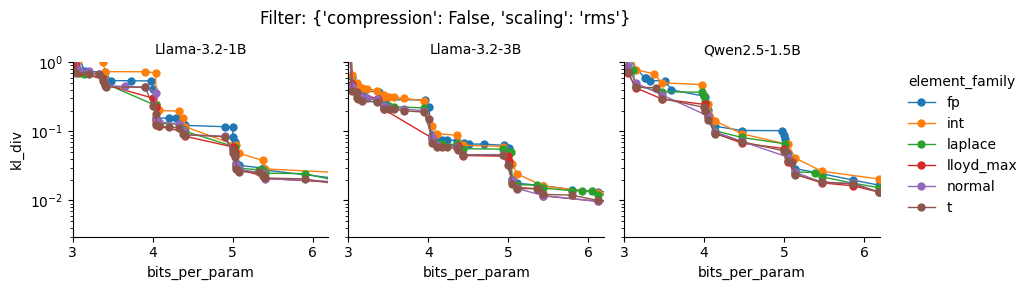

In [437]:
show_pareto(dict(compression=False, scaling="absmax"), hue="element_family")
show_pareto(dict(compression=False, scaling="rms"), hue="element_family")

### Asymmetric/Symmetric doesn't matter (for these models)

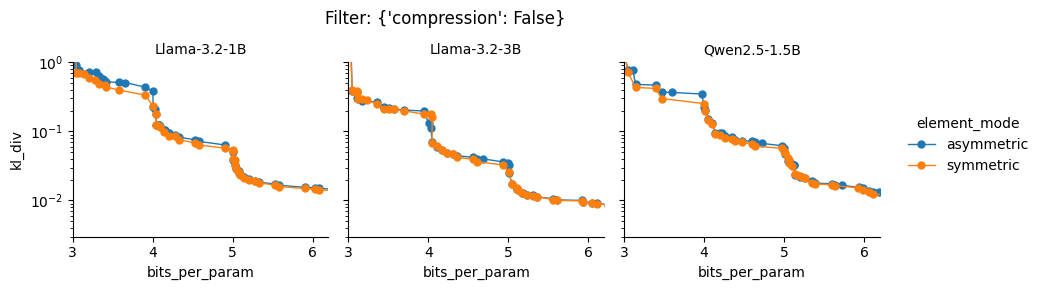

In [18]:
show_pareto(dict(compression=False), hue="element_mode")

### (Fisher) elementwise error weighting doesn't help

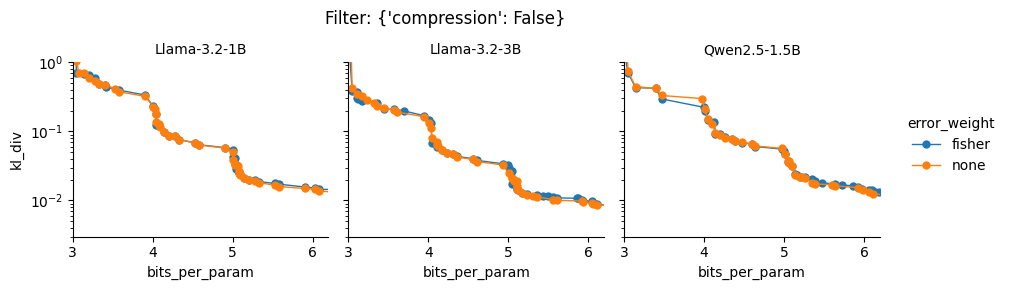

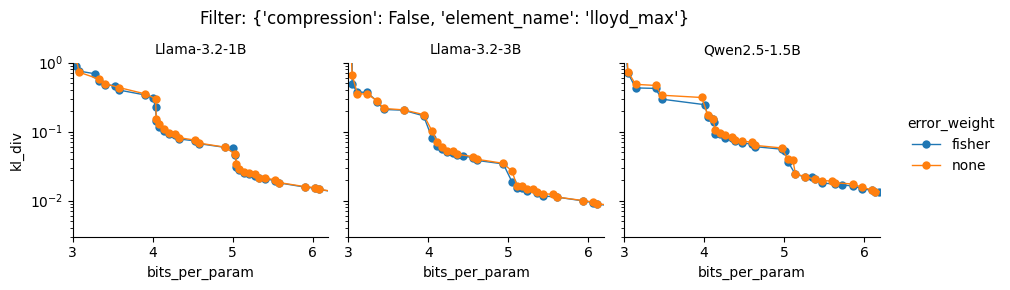

In [19]:
show_pareto(dict(compression=False), hue="error_weight")
show_pareto(dict(compression=False, element_name="lloyd_max"), hue="error_weight")

### bfloat16 outperforms exponent-only

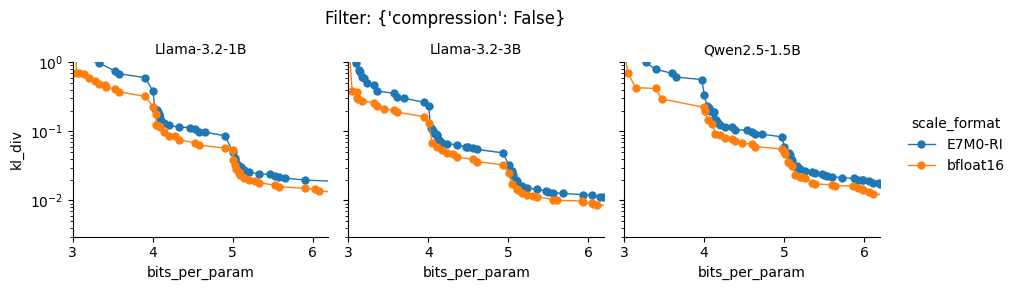

In [20]:
show_pareto(dict(compression=False), hue="scale_format")

### Fisher-weighted squared-error is a reasonable predictor of KL div

Excluding RMS-without-sparse and Fisher-error-weighted examples:


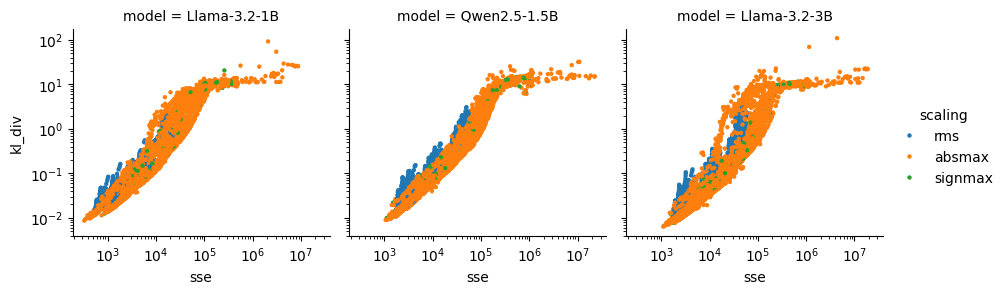

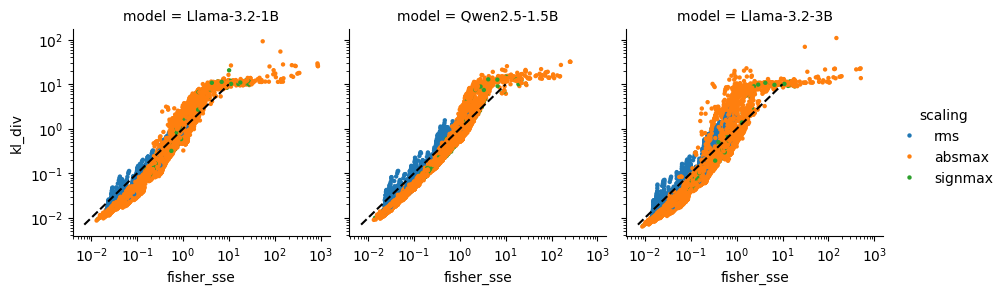

In [21]:
hue = "scaling"
d = df[~((df.scaling == "rms") & (df.sparse_ratio == 0)) & ~(df.error_weight == "fisher")]
print("Excluding RMS-without-sparse and Fisher-error-weighted examples:")
for x in ["sse", "fisher_sse"]:
    g = sns.relplot(data=d, y="kl_div", x=x, col="model", hue=hue, kind="scatter", height=3, lw=0, s=10)
    for ax in g.axes.flatten():
        ax.set_xscale("log")
        ax.set_yscale("log")
        if x == "fisher_sse":
            ax.plot([0.007, 10], [0.007, 10], "k--")

In [42]:
(df.pipe(lambda d: d[d.element_family == "t"])
 .pipe(lambda d: d[d.bit_allocation == "fixed"])
 .pipe(lambda d: d[d.model == "Llama-3.2-1B"])
#  .pipe(lambda d: d[d.element_mode == "asymmetric"])
 .pipe(lambda d: d[d.scaling == "rms"])
 .pipe(lambda d: d[d.scale_format == "bfloat16"])
 .pipe(lambda d: d[d.error_weight == "none"])
#  .pipe(lambda d: d[d.sparse_ratio == 0])
 .groupby(["element_bits", "element_name"]).apply(lambda d: d.loc[d.kl_div.idxmin()], include_groups=False).reset_index()
 [["element_bits", "element_name", "kl_div"]]
)

,element_bits,element_name,kl_div
0,3.0,t,0.633139
1,3.0,t[10],0.656062
2,3.0,t[30],0.656398
3,4.0,t,0.106597
4,4.0,t[10],0.113713
5,4.0,t[30],0.107280
6,5.0,t,0.024573
7,5.0,t[10],0.028687
8,5.0,t[30],0.024951
